In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from scripts.Models.ModelBuilder import ModelBuilder
from scripts.Models.CenterDetector.config import CFG as CCFG
from scripts.Models.PartsDetector.config import CFG as PCFG
import albumentations as A

In [128]:
class Controller:
    def __init__(self, original_image, image, desire_image_size=(512, 512)):
        self.original_image = original_image
        self.image = image
        self.desired_image_shape = desire_image_size

        self.center_detector_model, self.parts_detector_model = self.build_models()

    def get_cropped_image(self, backbone_coordinates):
        x_center_original, y_center_original = backbone_coordinates
        left_to_center, right_to_center = CCFG.img_size[0] // 2, CCFG.img_size[1] // 2

        shape_y = y_center_original - left_to_center if y_center_original > left_to_center else 0
        shape_x = x_center_original - right_to_center if x_center_original > right_to_center else 0

        cropped_image = self.original_image[shape_y: (y_center_original + right_to_center),
                        shape_x: (x_center_original + left_to_center)]

        return cropped_image

    def transform_label_coordinates_to_original(self, all_parts_predicted):
        return all_parts_predicted

    def add_labels_to_image(self, predicted_coordinates):
        pass

    def build_models(self):
        model_builder = ModelBuilder(CCFG, use_my_model=True, pretrained_model_path="CenterDetector/weights.bin")
        center_detector_model = model_builder.get_model()

        model_builder = ModelBuilder(PCFG, use_my_model=True, pretrained_model_path="PartsDetector/weights.bin")
        parts_detector_model = model_builder.get_model()

        return center_detector_model, parts_detector_model

    def get_predicted_image(self):
        with torch.no_grad():
            pred = self.center_detector_model(self.image)
            pred = (torch.nn.Sigmoid()(pred) > 0.5).double()

        pred = pred.cpu().detach()
        pred = torch.mean(pred[0], dim=0)
        coords = (pred==torch.max(pred)).nonzero()[0]

        y_scale = self.original_image.shape[0]//CCFG.img_size[0]
        x_scale = self.original_image.shape[1]//CCFG.img_size[1]
        coords = (coords[0]*x_scale, coords[1]*y_scale)

        center_cropped_image = self.get_cropped_image(coords)
        plt.imshow(center_cropped_image)
        # all_parts_predicted = self.parts_detector_model(center_cropped_image)
        # all_parts_predicted = self.transform_label_coordinates_to_original(all_parts_predicted)

        # return self.add_labels_to_image(all_parts_predicted)

In [129]:
data_transforms = A.Compose([
    A.Resize(*CCFG.img_size, interpolation=cv2.INTER_NEAREST),
    A.Normalize()
], p=1.0)

In [130]:
img_orig = cv2.imread("/home/raphael/Desktop/Repos/mouse_behaviour_tracker/scripts/Models/CenterDetector/images/WIN_20201123_1-1/0.jpg")
img = data_transforms(image=img_orig)["image"]
img = torch.tensor(img)
img = img.permute(-1, 0, 1)
img = torch.unsqueeze(img[0], 0)
img = img.to(CCFG.device, dtype=torch.float)
img = torch.unsqueeze(img, 0)
img.shape

torch.Size([1, 1, 512, 512])

x_scale 3
(tensor(789), tensor(452))


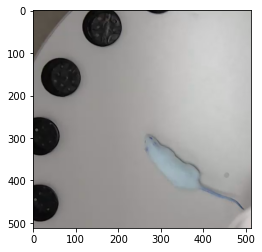

In [131]:
controller = Controller(img_orig, img)
controller.get_predicted_image()